In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, LabelBinarizer
from sklearn.model_selection import train_test_split


In [5]:
# Load your data
df = pd.read_csv('../data/cleaned/cleaned_vessel_calls.csv')

In [6]:
# Preprocess the dataframe
df["arrivalDate"] = pd.to_datetime(df["arrivalDate"])
df["sailingDate"] = pd.to_datetime(df["sailingDate"])
df["duration"] = (df["sailingDate"] - df["arrivalDate"]) / pd.Timedelta(days=1)
df["month"] = df["arrivalDate"].dt.month
df = df.dropna()

In [7]:
# cap any outliers
cap = df['duration'].quantile(.99)
df['capped_duration'] = df['duration'].apply(lambda x: min(x, cap))

In [8]:
# Sort and filter data
df.sort_values(by=["IMO", "arrivalDate"], inplace=True)
df['next_unlocode'] = df.groupby('IMO')['place.unlocode'].shift(-1)
df['is_last_imo'] = df['IMO'] != df['IMO'].shift(-1)
df = df[~df["is_last_imo"]]
df = df[df["Event_Type"] != "ARRIVAL"]

In [9]:
# Drop unnecessary columns
df = df.drop(columns=["is_last_imo", "Event_Type", "Timestamp", "vessel.vesselName", "IMO", "arrivalDate", "sailingDate"])

# Rename columns for consistency
df = df.rename(columns={'place.unlocode': 'current_unlocode', 'place.placeName': 'port_name', 'vessel.vesselType': 'vesselType', 'place.placeType': 'placeType', 'place.countryName': 'countryName'})

In [10]:
# Encode categorical features
label_encoders = {}
for column in ['countryName', 'vesselType', 'placeType']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column].astype(str))
    label_encoders[column] = le

In [11]:
# One-hot encode the port_unlocode feature
onehot_encoder = OneHotEncoder(sparse_output=False)
port_unlocode_encoded = onehot_encoder.fit_transform(df[['current_unlocode']])

In [12]:
# Add the one-hot encoded ports back to the dataframe
port_unlocode_df = pd.DataFrame(port_unlocode_encoded, columns=onehot_encoder.categories_[0])
df = pd.concat([df.reset_index(drop=True), port_unlocode_df], axis=1)
df = df.drop(columns=['current_unlocode'])

In [13]:
# Prepare features
X = df.drop(columns=['next_unlocode', 'port_name'])

# Encode target variable using LabelBinarizer
label_binarizer = LabelBinarizer()
y = label_binarizer.fit_transform(df['next_unlocode'])

In [14]:
# scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X[['duration', 'month', 'countryName', 'vesselType']] = scaler.fit_transform(X[['duration', 'month', 'countryName', 'vesselType']])

In [15]:
# Ensure all data is numeric
X = X.astype(np.float32)

In [16]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class PortPredictor(nn.Module):
    def __init__(self, input_size, output_size):
        super(PortPredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_size)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

input_size = X_train.shape[1]
output_size = y_train.shape[1]

model = PortPredictor(input_size, output_size)


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\ais_port_prediction\nn_env\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Users\sye

In [20]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [21]:
# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
model.train()

train_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    
    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tensor)
        outputs = torch.sigmoid(outputs)
        predicted = (outputs > 0.5).float()
        accuracy = (predicted.argmax(dim=1) == y_test_tensor.argmax(dim=1)).sum().item() / len(y_test_tensor)
        test_accuracies.append(accuracy)
    model.train()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Test Accuracy: {accuracy:.4f}')

Epoch 1/100, Loss: 0.0024, Test Accuracy: 0.0349
Epoch 2/100, Loss: 0.0023, Test Accuracy: 0.0358
Epoch 3/100, Loss: 0.0023, Test Accuracy: 0.0385
Epoch 4/100, Loss: 0.0023, Test Accuracy: 0.0420
Epoch 5/100, Loss: 0.0023, Test Accuracy: 0.0404
Epoch 6/100, Loss: 0.0023, Test Accuracy: 0.0459
Epoch 7/100, Loss: 0.0022, Test Accuracy: 0.0505
Epoch 8/100, Loss: 0.0022, Test Accuracy: 0.0446
Epoch 9/100, Loss: 0.0022, Test Accuracy: 0.0519
Epoch 10/100, Loss: 0.0022, Test Accuracy: 0.0532
Epoch 11/100, Loss: 0.0022, Test Accuracy: 0.0561
Epoch 12/100, Loss: 0.0022, Test Accuracy: 0.0562
Epoch 13/100, Loss: 0.0022, Test Accuracy: 0.0579
Epoch 14/100, Loss: 0.0022, Test Accuracy: 0.0579
Epoch 15/100, Loss: 0.0022, Test Accuracy: 0.0545
Epoch 16/100, Loss: 0.0022, Test Accuracy: 0.0510
Epoch 17/100, Loss: 0.0022, Test Accuracy: 0.0510
Epoch 18/100, Loss: 0.0022, Test Accuracy: 0.0507
Epoch 19/100, Loss: 0.0021, Test Accuracy: 0.0574
Epoch 20/100, Loss: 0.0021, Test Accuracy: 0.0524
Epoch 21/

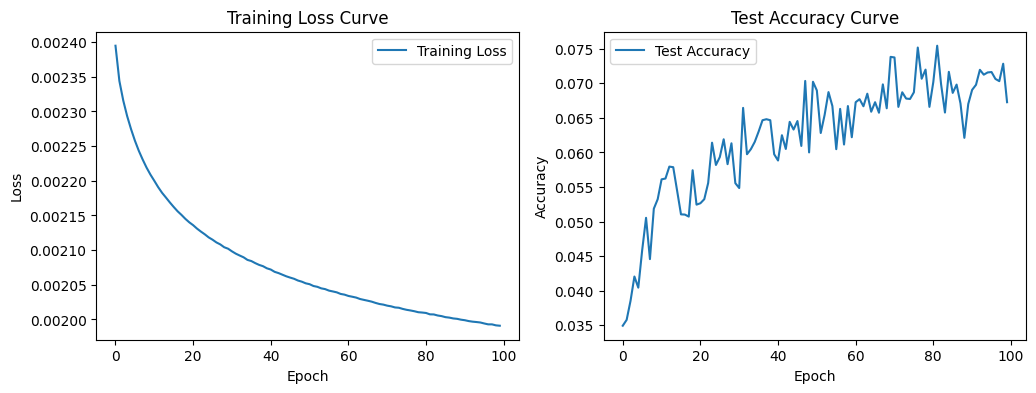

In [22]:
# Plot learning curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy Curve')
plt.legend()

plt.show()